## Overview
This notebook builds up a linear classifier of the cats & dogs image dataset from Kaggle. The images are first decomposed into keypoints via OpenCV's SIFT algorithm. The data from each keypoint is used to build a model (bag of visual words) that describes each image. The bag of visual words is then run through a linear classifier to determine whether each image is a cat or a dog. The model acheives roughly 73% accuracy when training on 5000 images and testing on 1000 images.

In [1]:
import boto3
import cv2
import io
from IPython.display import clear_output
from IPython.display import display
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import os
import pickle
import re
import sagemaker.amazon.common as smac
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role
from scipy.spatial.distance import cdist
import sys
from time import gmtime, strftime
import zipfile

## Open image file

In [41]:
archive = zipfile.ZipFile('train.zip')

In [42]:
train_files = [x for x in archive.namelist() if re.match('train.*jpg', x) is not None]

In [36]:
img_data = archive.read('train/dog.9455.jpg')

In [24]:
img = cv2.imdecode(np.frombuffer(img_data, np.uint8), 1)

In [25]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## Helper Functions

In [43]:
def generate_sift(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

In [44]:
def extract_desc(file):
    buf = archive.read(file)
    img = cv2.imdecode(np.frombuffer(buf, np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    kp, desc = generate_sift(img)
    
    num_desc = desc.shape[0]
    images = np.full((num_desc,1), file)
    
    return images, kp, desc

In [6]:
def run_extract(file_list):
    
    num_of_files = len(file_list)
    i = 1
    desc_total = None
    kp_total = None
    img_total = None
    
    for file in file_list:
        
        # Extract all SIFT keypoints and descriptors
        images, kp, desc = extract_desc(file)
        
        if i == 1:
            kp_total = kp
            desc_total = desc
            img_total = images
            clear_output(wait=True)
            print(i, "/", num_of_files, "completed")
            i = i + 1
            continue
            
        else:
            kp_total = np.append(kp_total, kp)
            desc_total = np.vstack((desc_total, desc))
            img_total = np.vstack((img_total, images))
            clear_output(wait=True)
            print(i, "/", num_of_files, "completed")
            i = i + 1
    
    
    #return img_total, kp_total, desc_total
    return desc_total

In [45]:
def extract_descriptors(file):
    # Read in file
    buf = archive.read(file)
    img = cv2.imdecode(np.frombuffer(buf, np.uint8), 1)
    
    # Convert to greyscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Extract keypoints and SIFT descriptors
    kp, desc = generate_sift(img)
    
    # Prep keypoints
    points = []
    for k, d in zip(kp, desc):
        point = (k.angle, k.class_id, k.convert, k.octave, k.overlap, k.pt, k.response, k.size, d)
        points.append(point)
    
    # Save to dictionary object
    output = {}
    output['filename'] = file
    output['kpd'] = points
    
    return output

In [27]:
points = []
for k, d in zip(kp, desc):
    point = (k.angle, k.class_id, k.convert, k.octave, k.overlap, k.pt, k.response, k.size, desc)
    points.append(point)

431

In [42]:
if not os.path.exists('train-descriptors'):
    os.makedirs('train-descriptors')

In [43]:
output = extract_descriptors(f)
save_name = output['filename'].split('/')[1]
file = open('train-descriptors/' + save_name + '.P', 'wb')
pickle.dump(output, file)

## Extract Keypoint Descriptors from images

In [ ]:
num_of_files = len(train_files)
i = 1
for f in train_files:
    output = extract_descriptors(f)
    save_name = output['filename'].split('/')[1]
    file = open('train-descriptors/' + save_name + '.P', 'wb')
    pickle.dump(output, file)
    clear_output(wait=True)
    print(i, "/", num_of_files, "completed")
    i += 1

In [15]:
ft = os.listdir('train-descriptors/')[:5000]
dogs = [f for f in ft if f.find('dog') != -1]
cats = [f for f in ft if f.find('cat') != -1]

prefix = 'train-descriptors/'

## Append all descriptors into one file

In [ ]:
descriptors = None
i = 0
for file in dogs:
    i += 1   
    f = 'train-descriptors/' + file
    with open(f, 'rb') as pf:
        a = pickle.load(pf)
        desc = [x[8] for x in a['kpd']]
        if descriptors is None:
            descriptors = desc
        else: descriptors = np.vstack((descriptors, desc))
            
    clear_output(wait=True)
    print(i)

In [60]:
print(sys.getsizeof(descriptors))

358960


In [126]:
file = open('train-descriptors.P', 'wb')
pickle.dump(descriptors, file)

In [134]:
file.close()

Descriptors for 2500 dog images, appended into one file is roughly 1.1 GB in size. This was uploaded via web browser to S3 bucket.

## Get data from S3 bucket

In [140]:
def write_s3_data(bucket, prefix, channel, X):
    buf = io.BytesIO()
    smac.write_numpy_to_dense_tensor(buf, X.astype('float32'))
    buf.seek(0)
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, channel + '.data')).upload_fileobj(buf)

In [2]:
# S3 bucket
bucket = 'catsvsdogs-ml'
prefix = 'sagemaker/DEMO-kmeans'

In [146]:
write_s3_data(bucket, prefix, 'train', descriptors)

## AWS Sagemaker Experiments to choose K

In [191]:
role = 'arn:aws:iam::536197384257:role/service-role/AmazonSageMaker-ExecutionRole-20190129T171919'

In [195]:
output_time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_folder = 'kmeans-lowlevel-' + output_time
K = range(50, 550, 50) # change the range to be used for k
#K = [500]
INSTANCE_COUNT = 1
run_parallel_jobs = False #make this false to run jobs one at a time, especially if you do not want 
#create too many EC2 instances at once to avoid hitting into limits.
job_names = []

In [196]:
image = get_image_uri(boto3.Session().region_name, 'kmeans')

In [197]:
# launching jobs for all k
for k in K:
    print('starting train job:' + str(k))
    output_location = 's3://{}/kmeans_example/output/'.format(bucket) + output_folder
    print('training artifacts will be uploaded to: {}'.format(output_location))
    job_name = output_folder + str(k)

    create_training_params = \
    {
        "AlgorithmSpecification": {
            "TrainingImage": image,
            "TrainingInputMode": "File"
        },
        "RoleArn": role,
        "OutputDataConfig": {
            "S3OutputPath": output_location
        },
        "ResourceConfig": {
            "InstanceCount": INSTANCE_COUNT,
            "InstanceType": "ml.c4.8xlarge",
            "VolumeSizeInGB": 50
        },
        "TrainingJobName": job_name,
        "HyperParameters": {
            "k": str(k),
            "feature_dim": "128",
            "mini_batch_size": "1000"
        },
        "StoppingCondition": {
            "MaxRuntimeInSeconds": 60 * 60
        },
            "InputDataConfig": [
            {
                "ChannelName": "train",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "S3Prefix",
                        "S3Uri": "s3://{}/{}/train.data".format(bucket, prefix),
                        "S3DataDistributionType": "FullyReplicated"
                    }
                },

                "CompressionType": "None",
                "RecordWrapperType": "None"
            }
        ]
    }

    sagemaker = boto3.client('sagemaker')

    sagemaker.create_training_job(**create_training_params)

    status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print(status)
    if not run_parallel_jobs:
        try:
            sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
        finally:
            status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
            print("Training job ended with status: " + status)
            if status == 'Failed':
                message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
                print('Training failed with the following error: {}'.format(message))
                raise Exception('Training job failed')
    
    job_names.append(job_name)

starting train job:50
training artifacts will be uploaded to: s3://catsvsdogs-ml/kmeans_example/output/kmeans-lowlevel-2019-03-18-07-47-39
InProgress
Training job ended with status: Completed
starting train job:100
training artifacts will be uploaded to: s3://catsvsdogs-ml/kmeans_example/output/kmeans-lowlevel-2019-03-18-07-47-39
InProgress
Training job ended with status: Completed
starting train job:150
training artifacts will be uploaded to: s3://catsvsdogs-ml/kmeans_example/output/kmeans-lowlevel-2019-03-18-07-47-39
InProgress
Training job ended with status: Completed
starting train job:200
training artifacts will be uploaded to: s3://catsvsdogs-ml/kmeans_example/output/kmeans-lowlevel-2019-03-18-07-47-39
InProgress
Training job ended with status: Completed
starting train job:250
training artifacts will be uploaded to: s3://catsvsdogs-ml/kmeans_example/output/kmeans-lowlevel-2019-03-18-07-47-39
InProgress
Training job ended with status: Completed
starting train job:300
training arti

In [198]:
# How to check training job status
response = sagemaker.describe_training_job(
    TrainingJobName='kmeans-lowlevel-2019-03-18-06-32-52500'
)
#response

## Inspecting Distortion

In [3]:
bucket

'catsvsdogs-ml'

Model for k=50 (kmeans_example/output/kmeans-lowlevel-2019-03-18-07-47-39/kmeans-lowlevel-2019-03-18-07-47-3950/output/model.tar.gz)
x model_algo-1
x state_f13371e0-e162-4257-adb8-6321bc88114a
Model for k=100 (kmeans_example/output/kmeans-lowlevel-2019-03-18-07-47-39/kmeans-lowlevel-2019-03-18-07-47-39100/output/model.tar.gz)
x state_932e0871-64fa-4f53-964e-2ce777498451
x model_algo-1
Model for k=150 (kmeans_example/output/kmeans-lowlevel-2019-03-18-07-47-39/kmeans-lowlevel-2019-03-18-07-47-39150/output/model.tar.gz)
x model_algo-1
x state_795a0e09-e2b5-4209-ac0c-d2bf43c62eb4
Model for k=200 (kmeans_example/output/kmeans-lowlevel-2019-03-18-07-47-39/kmeans-lowlevel-2019-03-18-07-47-39200/output/model.tar.gz)
x model_algo-1
x state_3704a49e-1047-447b-80a1-c777ed53a2f6
Model for k=250 (kmeans_example/output/kmeans-lowlevel-2019-03-18-07-47-39/kmeans-lowlevel-2019-03-18-07-47-39250/output/model.tar.gz)
x model_algo-1
x state_b3079804-e29d-4958-936e-f75b49bdbcc5
Model for k=300 (kmeans_exa

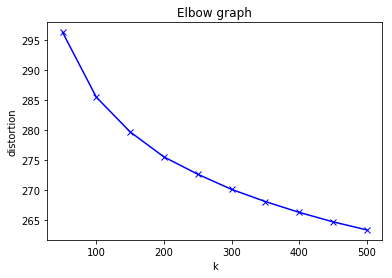

In [211]:
plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']
models = {}
distortions = []

for k in K:
    s3_client = boto3.client('s3')
    key = 'kmeans_example/output/' + output_folder +'/' + output_folder + str(k) + '/output/model.tar.gz'
    s3_client.download_file(bucket, key, 'model.tar.gz')
    print("Model for k={} ({})".format(k, key))
    !tar -xvf model.tar.gz 
    kmeans_model = mx.ndarray.load('model_algo-1')
    kmeans_numpy = kmeans_model[0].asnumpy()
    #print(kmeans_numpy.shape)
    #break
    distortions.append(sum(np.min(cdist(descriptors, kmeans_numpy, 'euclidean'), axis=1)) / descriptors.shape[0])
    models[k] = kmeans_numpy
    
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('distortion')
plt.title('Elbow graph')
plt.show()

Reading up on the elbow method, anywhere between 200-300 might be a good start for choosing K.

## Use model with K  = 300

In [4]:
model_300_path = 'kmeans_example/output/kmeans-lowlevel-2019-03-18-07-47-39/' + \
    'kmeans-lowlevel-2019-03-18-07-47-39300/output/model.tar.gz'

In [5]:
s3_client = boto3.client('s3')
s3_client.download_file(bucket, model_300_path, 'model.tar.gz')
!tar -xvf model.tar.gz
model_300 = mx.ndarray.load('model_algo-1')

x state_c5726545-cf1b-4569-92be-c381c0b13986
x model_algo-1


In [6]:
model_300 = model_300[0].asnumpy()
print(model_300.shape)

(300, 128)


In [7]:
def desc_to_visual_words(labels, K=1000):
    label_counts = np.zeros(1000)
    for k in range(1,K-1):
        count = np.where(labels == k)[0].shape[0]
        label_counts[k-1] = count
    return label_counts

### Convert dog image descriptors to visual dictionary

In [16]:
# Load pre-computed descriptors and translate to dictionary
prefix = 'train-descriptors/'
i = 0
x_trans = None
for file in dogs:
    i += 1
    with open(prefix+file, 'rb') as pf:
        dog = pickle.load(pf)
        
    desc = np.array([desc[8] for desc in dog['kpd']])
    
    y = np.argmin(cdist(desc, model_300, 'euclidean'), axis=1)
    
    x = np.bincount(y, minlength=300)
    
    if x_trans is None:
        x_trans = x
    else:
        x_trans = np.vstack((x_trans, x))
    clear_output(wait=True)
    print(i)
    
    
    #break

2492


### Convert cat image descriptors to visual dictionary

In [17]:
# Load pre-computed descriptors and translate to dictionary
prefix = 'train-descriptors/'
i = 0
x_trans_c = None
for file in cats:
    i += 1
    with open(prefix+file, 'rb') as pf:
        cat = pickle.load(pf)
        
    desc = np.array([desc[8] for desc in cat['kpd']])
    
    y = np.argmin(cdist(desc, model_300, 'euclidean'), axis=1)
    
    x = np.bincount(y, minlength=300)
    
    if x_trans_c is None:
        x_trans_c = x
    else:
        x_trans_c = np.vstack((x_trans_c, x))
    clear_output(wait=True)
    print(i)
    
    
    #break

2507


In [18]:
x_trans_c.shape

(2507, 300)

In [19]:
X_train = np.vstack((x_trans, x_trans_c))

In [45]:
y_train = np.concatenate((np.ones(2492), np.zeros(2507)))

## TF-IDF Matrix

In [46]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(norm="l2")
tfidf.fit(X_train)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [47]:
X_train_dense = tfidf.transform(X_train).todense()

In [48]:
X_train_dense.shape

(4999, 300)

## Prepare Test Dataset

In [49]:
fte = os.listdir('train-descriptors/')[7000:8000]
dogs_te = [f for f in fte if f.find('dog') != -1]
cats_te = [f for f in fte if f.find('cat') != -1]

prefix = 'train-descriptors/'

In [50]:
# Load pre-computed descriptors and translate to dictionary
prefix = 'train-descriptors/'
i = 0
xte_trans = None
for file in dogs_te:
    i += 1
    with open(prefix+file, 'rb') as pf:
        dog = pickle.load(pf)
        
    desc = np.array([desc[8] for desc in dog['kpd']])
    
    y = np.argmin(cdist(desc, model_300, 'euclidean'), axis=1)
    
    x = np.bincount(y, minlength=300)
    
    if xte_trans is None:
        xte_trans = x
    else:
        xte_trans = np.vstack((xte_trans, x))
    clear_output(wait=True)
    print(i)
    
    
    #break

502


In [51]:
# Load pre-computed descriptors and translate to dictionary
prefix = 'train-descriptors/'
i = 0
xte_trans_c = None
for file in cats_te:
    i += 1
    with open(prefix+file, 'rb') as pf:
        dog = pickle.load(pf)
        
    desc = np.array([desc[8] for desc in dog['kpd']])
    
    y = np.argmin(cdist(desc, model_300, 'euclidean'), axis=1)
    
    x = np.bincount(y, minlength=300)
    
    if xte_trans_c is None:
        xte_trans_c = x
    else:
        xte_trans_c = np.vstack((xte_trans_c, x))
    clear_output(wait=True)
    print(i)
    
    
    #break

498


In [52]:
X_test = np.vstack((xte_trans, xte_trans_c))

In [53]:
X_test.shape

(1000, 300)

In [54]:
X_test_dense = tfidf.transform(X_test).todense()

In [55]:
X_test_dense

matrix([[0.09514909, 0.        , 0.03915284, ..., 0.0291558 , 0.09425389,
         0.12373131],
        [0.01390993, 0.02086919, 0.06009977, ..., 0.02557388, 0.02755812,
         0.01808839],
        [0.03530266, 0.08827481, 0.        , ..., 0.04867885, 0.01748526,
         0.02295369],
        ...,
        [0.06197601, 0.06198877, 0.        , ..., 0.11394501, 0.03069646,
         0.08059324],
        [0.0274084 , 0.        , 0.03383479, ..., 0.05039127, 0.08145158,
         0.03564172],
        [0.        , 0.02329417, 0.05749998, ..., 0.06422746, 0.02307026,
         0.03028537]])

In [56]:
y_test = np.concatenate((np.ones(502), np.zeros(498)))

## Linear Model

In [57]:
X_train_dense.shape

(4999, 300)

In [58]:
len(list(range(0,5000)))

5000

In [59]:
from sklearn.utils import shuffle
ix = shuffle(list(range(0,4999)), random_state=3)
X_train_sh = X_train_dense[ix]
y_train_sh = y_train[ix]

In [60]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_sh, y_train_sh)

/Users/trekendrick/.virtualenvs/py3cv4/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [61]:
pred_tr = lr.predict(X_train_sh)

In [62]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train_sh, pred_tr)

0.752750550110022

## Testing Predictions

In [63]:
y_test.shape

(1000,)

In [64]:
pred_te = lr.predict(X_test_dense)

In [65]:
accuracy_score(y_test, pred_te)

0.739

### Save predictions column

In [67]:
X_all = np.vstack((X_train_sh, X_test_dense))
X_all.shape

(5999, 300)

In [75]:
y_all = np.concatenate((y_train_sh, y_test))
y_all = y_all.reshape((len(y_all),1))

In [79]:
import pandas as pd
pd.DataFrame(X_all).to_csv('x-all.csv')
pd.DataFrame(y_all).to_csv('y-all.csv')

In [84]:
f0_all = np.concatenate((pred_tr, pred_te))
f0_all = f0_all.reshape((len(f0_all), 1))
f0_all.shape

(5999, 1)

In [85]:
pd.DataFrame(f0_all).to_csv('f0-all.csv')

## Non-Linear Model

In [183]:
from sklearn.svm import SVC
svm = SVC()

In [184]:
svm.fit(X_train_sh, y_train_sh)

/Users/trekendrick/.virtualenvs/py3cv4/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [185]:
pred_tr = svm.predict(X_train_sh)
accuracy_score(y_train_sh, pred_tr)

0.6122

## Save Datasets

In [43]:
#file = open('datasets/x-train.P', 'wb')
#pickle.dump(X_train_sh, file)

#file = open('datasets/x-test.P', 'wb')
#pickle.dump(X_test_dense, file)

#file = open('datasets/y-train.P', 'wb')
#pickle.dump(y_train_sh, file)

file = open('datasets/y-test.P', 'wb')
pickle.dump(y_test, file)